In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
import pickle
f = open('dataset.pickle','r')
data = pickle.load(f)
f.close()
X,test_X,Y = data

In [3]:
print X.shape,Y.shape
print test_X.shape

(18359, 11) (18359,)
(15021, 11)


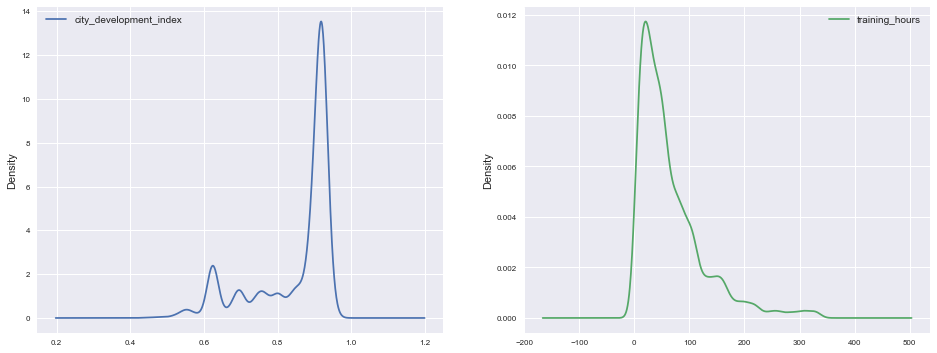

In [4]:
numerical_feats = ['city_development_index','training_hours']

X[numerical_feats].plot(figsize=(16,6),kind ='density',
                        subplots=True,sharex=False,layout = (1,2),fontsize=8);

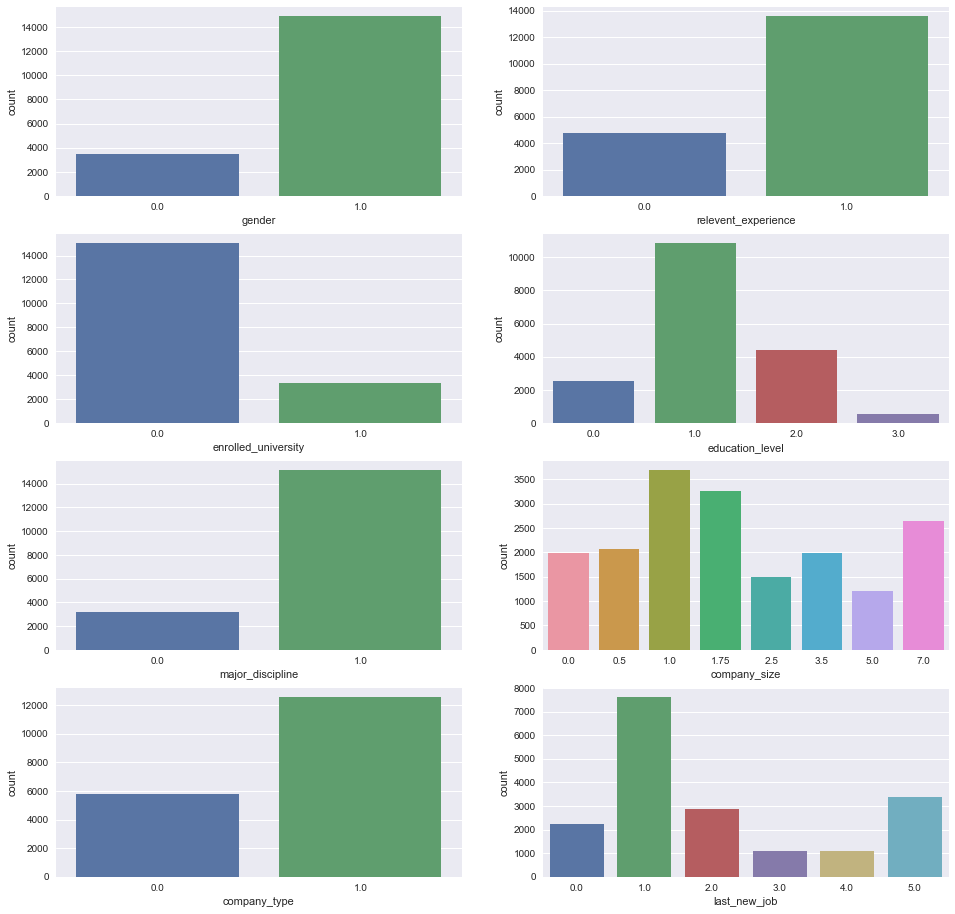

In [5]:
class_feats = ['gender','relevent_experience','enrolled_university','education_level','major_discipline',
              'company_size','company_type','last_new_job']
fig,ax = plt.subplots(4,2,figsize = (16,16))
for i in range(len(class_feats)):
    ix = i//2
    iy = i%2
    sns.countplot(X[class_feats[i]],ax=ax[ix,iy])

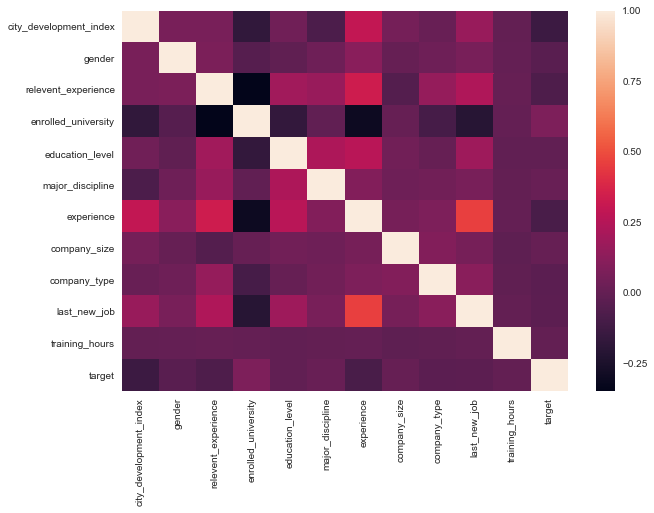

In [6]:
###Exploratory data analysis
#correlation matrix

temp_mat = X.copy()
temp_mat['target'] = Y
cor_mat = temp_mat.corr()
plt.figure(figsize=(10,7))
sns.heatmap(cor_mat)

In [7]:
#last_new_job is highly correllated with experience and relevent_experience 
X = X.drop(['experience','relevent_experience'],1)

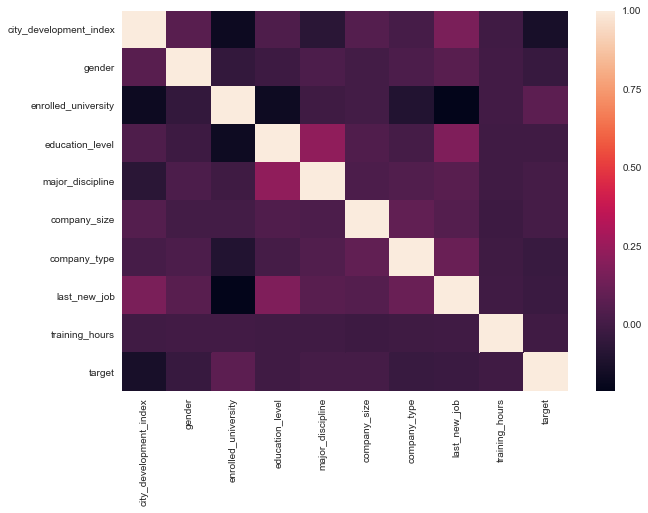

In [8]:
temp_mat = X.copy()
temp_mat['target'] = Y
cor_mat = temp_mat.corr()
plt.figure(figsize=(10,7))
sns.heatmap(cor_mat)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_curve,confusion_matrix
from sklearn.preprocessing import StandardScaler

In [10]:
class Model:
    def __init__(self,model,name= None):
        self.model = model
        self.name = name
        
    def fit(self,X,Y,scale = False,valid_ratio = 0.25):
        if scale:
            X = StandardScaler().fit_transform(X)
        self.X_train,self.X_valid,self.Y_train,self.Y_valid = train_test_split(X,Y,test_size = valid_ratio)
        self.model.fit(self.X_train,self.Y_train)
    
    #compute various error metrics on valid set
    def error_rate(self):
        self.scores = []
        valid_preds = self.model.predict(self.X_valid)
        fpr,tpr,threshold = roc_curve(self.Y_valid,valid_preds)
        self.scores.append((
            accuracy_score(self.Y_valid,valid_preds),
            precision_score(self.Y_valid,valid_preds),
            recall_score(self.Y_valid,valid_preds),
            f1_score(self.Y_valid,valid_preds),
            auc(fpr,tpr),
            confusion_matrix(self.Y_valid,valid_preds)
        ))
        return self.scores
        
    #define prediction function for new observations
    def predict(self,X):
        preds = self.model.predict(X)
        return preds

In [11]:
dct = GaussianNB()
model = Model(dct) 
model.fit(X.values,Y.values.ravel(),scale=True)
scores = model.error_rate()
pd.DataFrame(scores,columns=['Accuracy','Precision','Recall','F1','AUC ROC','Confusion Matrix'])

,Accuracy,Precision,Recall,F1,AUC ROC,Confusion Matrix
0,0.847059,0.256684,0.07856,0.120301,0.521813,"[[3840, 139], [563, 48]]"


In [12]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.metrics import classification_report_imbalanced

In [13]:
#helper functions
def transform(transformer,X,Y):
    name = transformer.__class__.__name__
    print 'Transforming : {}'.format(name)
    X_resampled,Y_resampled = transformer.fit_sample(X,Y)
    return name,X_resampled,Y_resampled

In [14]:
#applying transformations to the data
transformers = [RandomOverSampler,SMOTE,RandomUnderSampler,SMOTEENN,SMOTETomek]

datasets = []
datasets.append(('base',X.values,Y.values.ravel()))
for transformer in transformers:
    datasets.append(transform(transformer(),X.values,Y.values.ravel()))


Transforming : RandomOverSampler
Transforming : SMOTE
Transforming : RandomUnderSampler
Transforming : SMOTEENN
Transforming : SMOTETomek


In [15]:
lrc = LogisticRegression()
dtc = DecisionTreeClassifier()
nbc = GaussianNB()
svc = SVC()
rfc = RandomForestClassifier(n_estimators=100)

models = [(lrc,'Logistic Regression',True)
          ,(dtc,'Decision Tree Classifier',False),
          (nbc,'Gaussian Naive Bayes',True),
          (svc,'SVC',True),
          (rfc,'Random Forest Classifier',False)]

for classifier,classifier_name,scale in models:
    model = Model(classifier,classifier_name)
    model_scores = []
    for sample_type,X,Y in datasets:
        model.fit(X,Y,scale = scale)
        score = [sample_type] + list(model.error_rate()[0])
        model_scores.append(score)
    #print model_scores
    print '-'*80
    print classifier_name
    
    temp = pd.DataFrame(model_scores,columns = ['Sample Type','Accuracy','Precision','Recall',
                                                'F1','AUC ROC',
                                                'Confusion Matrix'])
    temp.index = temp['Sample Type']
    temp = temp.drop('Sample Type',axis=1)
    print temp

/home/t1/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/t1/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------------------------------------
Logistic Regression
                    Accuracy  Precision    Recall        F1   AUC ROC  \
Sample Type                                                             
base                0.867538   0.000000  0.000000  0.000000  0.500000   
RandomOverSampler   0.590561   0.602210  0.499491  0.546062  0.589310   
SMOTE               0.607380   0.628735  0.523235  0.571154  0.607328   
RandomUnderSampler  0.590272   0.648421  0.482759  0.553459  0.596162   
SMOTEENN            0.670377   0.689371  0.846248  0.759797  0.617227   
SMOTETomek          0.594899   0.622045  0.496051  0.551949  0.595498   

                                Confusion Matrix  
Sample Type                                       
base                       [[3982, 0], [608, 0]]  
RandomOverSampler   [[2743, 1296], [1966, 1962]]  
SMOTE               [[2756, 1230], [1898, 2083]]  
RandomUnderSampler      [[408, 167], [330, 308]]  
SMOTEENN

/home/t1/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/t1/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------------------------------------
SVC
                    Accuracy  Precision    Recall        F1   AUC ROC  \
Sample Type                                                             
base                0.873856   0.000000  0.000000  0.000000  0.500000   
RandomOverSampler   0.613782   0.628455  0.545455  0.584021  0.613381   
SMOTE               0.758755   0.832359  0.645665  0.727221  0.758317   
RandomUnderSampler  0.564716   0.565678  0.452542  0.502825  0.561745   
SMOTEENN            0.782264   0.832486  0.806839  0.819462  0.775133   
SMOTETomek          0.764706   0.844064  0.647377  0.732751  0.764301   

                                Confusion Matrix  
Sample Type                                       
base                       [[4011, 0], [579, 0]]  
RandomOverSampler   [[2730, 1277], [1800, 2160]]  
SMOTE                [[3483, 516], [1406, 2562]]  
RandomUnderSampler      [[418, 205], [323, 267]]  
SMOTEENN              [[

In [16]:
_,X,Y = datasets[1]
rfc = RandomForestClassifier(n_estimators=100)
model = Model(rfc)
model.fit(X,Y)

In [17]:
test_X = test_X.drop(['experience','relevent_experience'],axis=1)
test_preds = model.predict(test_X.values)

In [18]:
sample_subs = pd.read_csv('data/sample_submission_sxfcbdx.csv')

In [19]:
sample_subs['target'] = test_preds

In [20]:
sample_subs.index = sample_subs['enrollee_id']
sample_subs = sample_subs.drop(['enrollee_id'],axis=1)
sample_subs.to_csv('test_preds.csv')